# 1. (02/26)오존 파일(Ozone.csv)을 이용하여 linear regression 구현
   
   tensorflow, python, sklearn으로 구현하고 결과를 비교해보아요!


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats     
import tensorflow as tf     
from sklearn import linear_model  
from sklearn.preprocessing import MinMaxScaler 

df = pd.read_csv('data/ozone.csv')
training_data = df[['Temp','Ozone']]   # 153 rows × 2 columns

training_data = training_data.dropna(how='any')
zscore_threshold = 1.8

tmp = ~(np.abs(stats.zscore(training_data['Temp'])) > zscore_threshold)
training_data = training_data.loc[tmp]

tmp = ~(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)
training_data = training_data.loc[tmp]

scaler_x = MinMaxScaler()  # 객체 생성
scaler_t = MinMaxScaler()  # 객체 생성
scaler_x.fit(training_data['Temp'].values.reshape(-1,1))
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))

training_data['Temp'] = scaler_x.transform(training_data['Temp'].values.reshape(-1,1))
training_data['Ozone'] = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

display(training_data)


# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

X = tf.placeholder(shape=[None,1], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

W = tf.Variable(tf.random.normal([1,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

H = tf.matmul(X,W) + b

loss = tf.reduce_mean(tf.square(H-T))

train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], 
                                         feed_dict={X: x_data, T: t_data})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_val))

        

,Temp,Ozone
0,0.181818,0.397849
1,0.333333,0.344086
2,0.393939,0.086022
3,0.030303,0.150538
5,0.151515,0.258065
...,...,...
147,0.060606,0.107527
148,0.272727,0.279570
150,0.424242,0.107527
151,0.454545,0.150538


W : [[-0.08548696]], b : [0.47258604], loss : 0.08757279813289642
W : [[0.1369359]], b : [0.30351886], loss : 0.05950722098350525
W : [[0.3145137]], b : [0.20854798], loss : 0.04587747901678085
W : [[0.44415572]], b : [0.13923441], loss : 0.038614001125097275
W : [[0.53878486]], b : [0.08863439], loss : 0.034743476659059525
W : [[0.6078581]], b : [0.05170313], loss : 0.032680947333574295
W : [[0.6582723]], b : [0.02474534], loss : 0.03158184513449669
W : [[0.69510573]], b : [0.00506965], loss : 0.030995693057775497
W : [[0.7219248]], b : [-0.00928552], loss : 0.03068387694656849
W : [[0.7415235]], b : [-0.01976709], loss : 0.03051742911338806


In [21]:
# sklearn
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

model = linear_model.LinearRegression()
model.fit(x_data,t_data)

print('W : {}, b : {}'.format(model.coef_, model.intercept_))

W : [[0.79468511]], b : [-0.04818192]


# (03/04) Kaggle Titanic Logistic Regression 구현

=> 데이터 전처리

=> 모델 구현

=> 결과 파일 생성 후 Kaggle에 upload

=> 모델 accuracy 확인

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf

df = pd.read_csv('data/titanic/train.csv')

df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], 
        axis=1, 
        inplace=True)

gender_mapping = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(gender_mapping)

df['Family'] = df['SibSp'] + df['Parch']
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

df['Embarked'] = df['Embarked'].fillna('Q')
embarked_mapping = {'S': 0, 'C': 1, 'Q':2 }
df['Embarked'] = df['Embarked'].map(embarked_mapping)

df['Age'] = df['Age'].fillna(df['Age'].mean())

df.loc[df['Age'] < 8,'Age'] = 0
df.loc[(df['Age'] >= 8) & (df['Age'] < 20),'Age'] = 1
df.loc[(df['Age'] >= 20) & (df['Age'] < 65),'Age'] = 2
df.loc[df['Age'] >= 65,'Age'] = 3

train_data = df.iloc[:int(df.shape[0] * 0.7)]
val_data = df.iloc[int(df.shape[0] * 0.7):]

train_x_data = train_data.drop(['Survived'], axis=1, inplace=False).values
train_t_data = train_data['Survived'].values.reshape(-1,1)

val_x_data = val_data.drop(['Survived'], axis=1, inplace=False).values
val_t_data = val_data['Survived'].values.reshape(-1,1)


# Tensorflow

X = tf.placeholder(shape=[None,5], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

W = tf.Variable(tf.random.normal([5,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

logit = tf.matmul(X,W) + b
H = tf.sigmoid(logit)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit,
                                                              labels=T))
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train,W,b,loss], 
                                         feed_dict={X: train_x_data,
                                                    T: train_t_data})
    if step % 30000 == 0:
        print('W:{}, b:{}. loss:{}'.format(W_val,b_val,loss_val))

W:[[-1.072872  ]
 [ 1.3758383 ]
 [ 1.3270931 ]
 [ 0.12018275]
 [ 1.6541159 ]], b:[-0.873694]. loss:1.0864496231079102
W:[[-1.2141813 ]
 [ 1.4846269 ]
 [ 1.0400374 ]
 [ 0.18109839]
 [ 0.7109184 ]], b:[-0.9824224]. loss:0.6402943134307861
W:[[-1.0133672 ]
 [ 1.6387012 ]
 [ 0.92907774]
 [ 0.26228443]
 [ 0.3155667 ]], b:[-0.9409091]. loss:0.5559896230697632
W:[[-0.87275773]
 [ 1.7732081 ]
 [ 0.78247654]
 [ 0.30397153]
 [ 0.16791564]], b:[-0.9078378]. loss:0.5272644758224487
W:[[-0.77652997]
 [ 1.8895631 ]
 [ 0.6441156 ]
 [ 0.32676947]
 [ 0.1075289 ]], b:[-0.87592137]. loss:0.5114445686340332
W:[[-0.7077993 ]
 [ 1.9902191 ]
 [ 0.5271966 ]
 [ 0.34076545]
 [ 0.07437386]], b:[-0.8413005]. loss:0.5010635256767273
W:[[-0.6581973 ]
 [ 2.0777454 ]
 [ 0.43132088]
 [ 0.34987578]
 [ 0.05102314]], b:[-0.8040406]. loss:0.4939332604408264
W:[[-0.6226016 ]
 [ 2.1533911 ]
 [ 0.35298836]
 [ 0.35597295]
 [ 0.03237234]], b:[-0.76435333]. loss:0.48888063430786133
W:[[-0.59752464]
 [ 2.2200205 ]
 [ 0.28850266]

In [50]:
test = pd.read_csv('data/titanic/test.csv')


In [51]:
# 정확도(Accuracy)
predict = tf.cast(H > 0.5, dtype=tf.float32)  
correct = tf.equal(predict, T) 
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

accuracy_val = sess.run(accuracy, feed_dict={X:val_x_data,
                                             T:val_t_data})
print('모델의 정확도 : {}'.format(accuracy_val))

모델의 정확도 : 0.7835820913314819


In [54]:
print(predict)

Tensor("Cast_10:0", shape=(?, 1), dtype=float32)


# 3. (03/08) BMI 데이터를 이용해서 모델 구현과 평가를 진행

=> 데이터 전처리 

=> 모델 구현

=> K-Fold Cross Validation을 이용해서 모델 검증

=> 우리모델의 최종 정확도를 출력!


In [24]:
# Multinomial Classification
# %reset

# Tensorflow로 구현해 보아요!
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Raw Data Loading
df = pd.read_csv('data/bmi.csv')

# display(df.head(), df.shape)

### 결측치 처리 ###
# df.isnull().sum()   # 결측치가 존재하지 않아요!

### 이상치 처리 ###


In [25]:
df[df['label']=='thin']=0
df[df['label']=='normal']=1
df[df['label']=='fat']=2

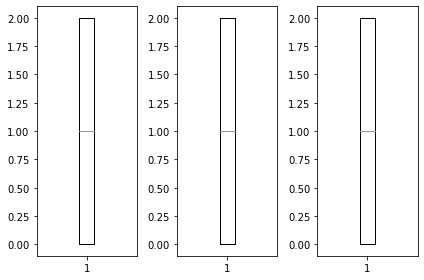

In [26]:
fig = plt.figure()
fig_1 = fig.add_subplot(1,3,1)
fig_2 = fig.add_subplot(1,3,2)
fig_3 = fig.add_subplot(1,3,3)

fig_1.boxplot(df['label'])
fig_2.boxplot(df['height'])
fig_3.boxplot(df['weight'])

fig.tight_layout()
plt.show()


In [27]:
### boxplot을 이용해서 이상치가 존재하는지를 확인해요!!
### 이상치는 현재 존재하지 않아요!

### Training Data Set
x_data = df[['height', 'weight']].values
t_data = df['label'].values  # one hot encoding으로 변환
###      [0 1 2 0 1 1 2 2 0 1]
###      [[1 0 0]
###       [0 1 0]
###       [0 0 1]
###       [1 0 0]]

### 정규화
scaler_x = MinMaxScaler()
scaler_x.fit(x_data)
norm_x_data = scaler_x.transform(x_data)
# print(norm_x_data)

### tensorflow 기능을 이용해서 one hot encoding을 생성
sess = tf.Session()
norm_t_data = sess.run(tf.one_hot(t_data, depth=3))
# print(norm_t_data)

## training data set 준비 끝


In [28]:


## tensorflow 구현
# placeholder
X = tf.placeholder(shape=[None,2], dtype=tf.float32)
T = tf.placeholder(shape=[None,3], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([2,3]), name='weight')
b = tf.Variable(tf.random.normal([3]), name='bias')

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)   # Softmax Activation function 이용

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# 초기화
sess.run(tf.global_variables_initializer())

# 학습진행
for step in range(30000):
    _, W_val, b_val, loss_val = sess.run([train,W,b,loss], 
                                         feed_dict={X:norm_x_data,
                                                    T:norm_t_data})
    if step % 3000 == 0:
        print('W : {}, b: {}, loss: {}'.format(W_val, b_val, loss_val))
        
        

W : [[-0.9541866  -0.2607364   0.36329922]
 [-1.3072284  -0.5005514   1.0764552 ]], b: [-0.15847999 -1.37737     0.8283681 ], loss: 1.4497565031051636
W : [[-0.95799404 -0.22015437  0.32652497]
 [-1.3110527  -0.45996827  1.0396862 ]], b: [-0.09397605 -1.3023121   0.68880016], loss: 1.3320428133010864
W : [[-0.9627257  -0.1807635   0.29186594]
 [-1.3157761  -0.42057735  1.0050223 ]], b: [-0.03439944 -1.2300568   0.55696964], loss: 1.2263470888137817
W : [[-0.9684846  -0.14288004  0.259741  ]
 [-1.3215348  -0.38269386  0.97289604]], b: [ 0.02021093 -1.1610235   0.43332264], loss: 1.1328489780426025
W : [[-0.97534037 -0.10684442  0.23056403]
 [-1.3283985  -0.3466579   0.94371885]], b: [ 0.06995183 -1.0956184   0.31817994], loss: 1.0514580011367798
W : [[-0.98333377 -0.07299863  0.20470862]
 [-1.3363919  -0.31281245  0.91786337]], b: [ 0.11504384 -1.0342273   0.21169676], loss: 0.9817600846290588
W : [[-0.99244314 -0.04165482  0.18247376]
 [-1.3455015  -0.2814683   0.8956287 ]], b: [ 0.155

In [29]:
# 잘 만들어진 모델인지 확인하고 넘어가야 해요!(train, validation)

# prediction
height = 187
weight = 78
my_state = [[height, weight]]

result = sess.run(H, feed_dict={X:scaler_x.transform(my_state)})
print(result)  # 2 => 과체중 ?? 확인을 해 봐야 해요!

[[0.0000000e+00 1.5464582e-21 1.0000000e+00]]


In [67]:
# Multinomial Classification
# BMI 예제

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler       
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, cross_val_score

df = pd.read_csv('data/bmi.csv')

df[df['label']=='thin']=0
df[df['label']=='normal']=1
df[df['label']=='fat']=2

x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df[['height', 'weight']],df['label'], 
                 test_size=0.3, 
                 random_state=0)  
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=3))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=3))

X = tf.placeholder(shape=[None,2], dtype=tf.float32)
T = tf.placeholder(shape=[None,3], dtype=tf.float32)

W = tf.Variable(tf.random.normal([2,3]), name='weight')
b = tf.Variable(tf.random.normal([3]), name='bias')

logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)  # softmax activation function

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))

train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

num_of_epoch = 1000
batch_size = 100

def run_train(sess,train_x, train_t):
    print('### 학습 시작 ###')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]           
            _, loss_val = sess.run([train,loss],
                                   feed_dict={X: batch_x,
                                              T: batch_t})
            
        if step % 100 == 0:
            print('Loss : {}'.format(loss_val))
    print('### 학습 종료 ###')
    


In [68]:
# Accuracy 측정(정확도)    
predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(T,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

# 학습부터 해요!
run_train(sess,x_data_train_norm, t_data_train_onehot)
# Training Data Set을 이용하여 성능평가!
result = sess.run(accuracy, feed_dict={X:x_data_train_norm,
                                       T:t_data_train_onehot})
print('Accuracy : {}'.format(result))

### 학습 시작 ###
Loss : 0.599937915802002
Loss : 0.018289057537913322
Loss : 0.009028442203998566
Loss : 0.005980334244668484
Loss : 0.004467949736863375
Loss : 0.0035650914069265127
Loss : 0.0029652684461325407
Loss : 0.002538018859922886
Loss : 0.0022182499524205923
Loss : 0.0019699735566973686
### 학습 종료 ###
Accuracy : 1.0


In [72]:
kfold = KFold(n_splits=5, shuffle=True)

In [81]:
# 우리의 모델의 성능평가를 하기 위해
# K-Fold Cross Validation을 수행!

cv = 5          # Fold의 수
results = []    # 각 Fold당 학습과 성능평가가 진행되는데 
                # 이때 계산된 성능평가 값을 저장
kf = KFold(n_splits=cv, shuffle=True) 

for training_idx, validation_idx in kf.split(x_data_train_norm):
    training_x = x_data_train_norm[training_idx] # Fancy indexing
    training_t = t_data_train_onehot[training_idx]
    
    val_x = x_data_train_norm[validation_idx]
    val_t = t_data_train_onehot[validation_idx]
    
    # 학습부터 시켜야 해요!
    run_train(sess,training_x,training_t)
    results.append(sess.run(accuracy, feed_dict={X:val_x, T:val_t}))

print('측정한 각각의 결과값 : {}'.format(results))
print('최종 K-Fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))


### 학습 시작 ###
Loss : 0.7345197796821594
Loss : 0.02289043366909027
Loss : 0.011269760318100452
Loss : 0.00745403952896595
Loss : 0.005563901271671057
Loss : 0.004436832387000322
Loss : 0.003688717493787408
Loss : 0.003156110877171159
Loss : 0.002757722744718194
Loss : 0.0024485376197844744
### 학습 종료 ###
### 학습 시작 ###
Loss : 0.6733357310295105
Loss : 0.021811593323946
Loss : 0.010744583792984486
Loss : 0.007108038756996393
Loss : 0.005306101404130459
Loss : 0.0042315032333135605
Loss : 0.0035181802231818438
Loss : 0.0030102247837930918
Loss : 0.0026303217746317387
Loss : 0.0023353714495897293
### 학습 종료 ###
### 학습 시작 ###
Loss : 0.6346425414085388
Loss : 0.022727208212018013
Loss : 0.01120817568153143
Loss : 0.007417548913508654
Loss : 0.005538291297852993
Loss : 0.004417128395289183
Loss : 0.0036728063132613897
Loss : 0.0031428185757249594
Loss : 0.002746308222413063
Loss : 0.002438456518575549
### 학습 종료 ###
### 학습 시작 ###
Loss : 0.5581752061843872
Loss : 0.02235051803290844
Loss : 0.0110

# (03/09) MNIST 데이터를 이용하여 모델 구현과 평가 진행

    + 직접 손글씨로 쓴 예측용 데이터 생성 후 Prediction
    
    - 데이터는 Kaggle
    - Multiclass Classification
    - K-Fold Cross Validation
    - 우리 모델의 최종 정확도
    - 제출 파일 생성
    - 직접 쓴 손글씨씨로 예측용 데이터 생성

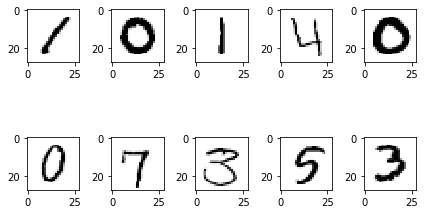

In [82]:
# MNIST 구현

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

df = pd.read_csv('data/mnist/train.csv')

img_data = df.drop('label', axis=1, inplace=False).values

fig = plt.figure()
fig_arr = []   # 10개의 subplot을 만들고 그 각각의 subplot을 list에 저장

for n in range(10):
    fig_arr.append(fig.add_subplot(2,5,n+1))
    fig_arr[n].imshow(img_data[n].reshape(28,28),
                     cmap='Greys',
                     interpolation='nearest')
plt.tight_layout()
plt.show()

x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('label', axis=1, inplace=False),
                df['label'],
                test_size=0.3,
                random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_data_train)

x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

# Tensorflow 구현
sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=10))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=10))

X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

W = tf.Variable(tf.random.normal([784,10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)  

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

num_of_epoch = 1000
batch_size = 100

def run_train(sess,train_x, train_t):
    print('### 학습 시작 ###')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]           
            _, loss_val = sess.run([train,loss],
                                   feed_dict={X: batch_x,
                                              T: batch_t})
            
        if step % 100 == 0:
            print('Loss : {}'.format(loss_val))
    print('### 학습 종료 ###')


In [83]:
    
# Accuracy 측정(정확도)    
predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(T,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

# 학습부터 해요!
run_train(sess,x_data_train_norm, t_data_train_onehot)

# Training Data Set을 이용하여 성능평가!
print('### Training Data Set을 이용하여 성능평가!! ###')
result = sess.run(accuracy, feed_dict={X:x_data_train_norm,
                                       T:t_data_train_onehot})
print('Accuracy : {}'.format(result))


### 학습 시작 ###
Loss : 1.6480169296264648
Loss : 0.2217538058757782
Loss : 0.18772602081298828
Loss : 0.1705520749092102
Loss : 0.16167517006397247
Loss : 0.15637896955013275
Loss : 0.15283294022083282
Loss : 0.15027719736099243
Loss : 0.1483117640018463
Loss : 0.1467011570930481
### 학습 종료 ###
### Training Data Set을 이용하여 성능평가!! ###
Accuracy : 0.947074830532074


In [84]:
cv = 5          
results = []    
kf = KFold(n_splits=cv, shuffle=True) 

for training_idx, validation_idx in kf.split(x_data_train_norm):
    training_x = x_data_train_norm[training_idx] # Fancy indexing
    training_t = t_data_train_onehot[training_idx]
    
    val_x = x_data_train_norm[validation_idx]
    val_t = t_data_train_onehot[validation_idx]
    
    run_train(sess,training_x,training_t)
    results.append(sess.run(accuracy, feed_dict={X:val_x, T:val_t}))

print('측정한 각각의 결과값 : {}'.format(results))
print('최종 K-Fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))


### 학습 시작 ###
Loss : 2.235882520675659
Loss : 0.1900482028722763
Loss : 0.14289496839046478
Loss : 0.1271662712097168
Loss : 0.12089629471302032
Loss : 0.11810822784900665
Loss : 0.116573266685009
Loss : 0.11548322439193726
Loss : 0.11455453932285309
Loss : 0.11368319392204285
### 학습 종료 ###
### 학습 시작 ###
Loss : 1.6875433921813965
Loss : 0.1368369311094284
Loss : 0.11682471632957458
Loss : 0.10662353783845901
Loss : 0.10144385695457458
Loss : 0.09857798367738724
Loss : 0.09682849794626236
Loss : 0.09561607986688614
Loss : 0.09464587271213531
Loss : 0.09376668184995651
### 학습 종료 ###
### 학습 시작 ###
Loss : 2.3016552925109863
Loss : 0.22651632130146027
Loss : 0.16226215660572052
Loss : 0.14295029640197754
Loss : 0.1359863132238388
Loss : 0.13382184505462646
Loss : 0.13364914059638977
Loss : 0.1342475712299347
Loss : 0.13505320250988007
Loss : 0.1358078271150589
### 학습 종료 ###
### 학습 시작 ###
Loss : 2.3731579780578613
Loss : 0.29282209277153015
Loss : 0.21724914014339447
Loss : 0.190598264336586

In [85]:
# Testing
run_train(sess,x_data_train_norm,t_data_train_onehot)
final_accuracy = sess.run(accuracy, feed_dict={X:x_data_test_norm,
                                               T:t_data_test_onehot})
print('우리 Model의 최종 정확도는 : {}'.format(final_accuracy))



### 학습 시작 ###
Loss : 1.88344407081604
Loss : 0.2133547067642212
Loss : 0.17206676304340363
Loss : 0.1563841700553894
Loss : 0.14800800383090973
Loss : 0.14318135380744934
Loss : 0.14017194509506226
Loss : 0.1380869448184967
Loss : 0.13648924231529236
Loss : 0.13516248762607574
### 학습 종료 ###
우리 Model의 최종 정확도는 : 0.9135714173316956


In [86]:
# 만약 Precision, Recall, F1, Accuracy를 각각 구하고 싶으면?
# 첫번째 인자로 정답이 들어가야 해요(one hot encoding이 안된형태)
target_names=['num 0', 'num 1', 'num 2', 'num 3', 'num 4', 'num 5',
              'num 6', 'num 7', 'num 8', 'num 9']
print(
classification_report(t_data_test,
                     sess.run(predict, feed_dict={X:x_data_test_norm}),
                     target_names = target_names))

              precision    recall  f1-score   support

       num 0       0.95      0.95      0.95      1242
       num 1       0.95      0.97      0.96      1429
       num 2       0.91      0.89      0.90      1276
       num 3       0.90      0.89      0.89      1298
       num 4       0.92      0.91      0.92      1236
       num 5       0.87      0.88      0.87      1119
       num 6       0.93      0.95      0.94      1243
       num 7       0.94      0.92      0.93      1334
       num 8       0.88      0.87      0.87      1204
       num 9       0.88      0.89      0.89      1219

    accuracy                           0.91     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.91      0.91      0.91     12600



In [87]:
# sample code로 confusion matrix를 출력해보아요!
# 3개의 label(정답)이 있는 multinomial classification에 대해
# 예측값을 넣어서 confusion matrix를 출력해 보아요!

from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0,1]
y_pred = [0, 0, 2, 2, 0,2]

print(confusion_matrix(y_true,y_pred))

[[2 0 0]
 [0 0 1]
 [1 0 2]]


In [88]:
print(
confusion_matrix(t_data_test,
                     sess.run(predict, feed_dict={X:x_data_test_norm})))

[[1183    0   11    5    2   12   20    1    7    1]
 [   1 1387    8    6    1    3    5    1   14    3]
 [  10   17 1134   34   15    9   17   10   24    6]
 [   7    3   32 1152    2   47    4    8   25   18]
 [   2   14   10    2 1126    4   14    6   11   47]
 [   9    8    8   31    7  982   20    4   38   12]
 [  11    2   10    0   17   15 1181    0    6    1]
 [   4    6   15    6   18    5    0 1227    9   44]
 [   6   15   13   35    7   43   11    4 1050   20]
 [  12    3    3   15   30   13    0   41   13 1089]]


(225, 225, 3)
(225, 225)


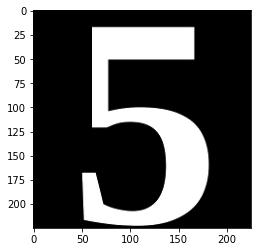

이미지의 크기 : 50625
이미지의 shape : (225, 225)


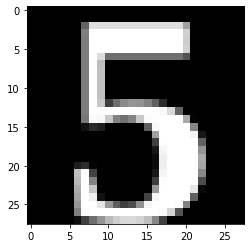

In [89]:
# 실제 이미지를 가지고 예측을 해 보아요!
# 이게 어려워요! 이미지 처리를 해야해요!

# 이미지를 하나 구해야 해요!
# 구한 color 이미지를 grey 이미지로 변환 => opencv를 이용

import numpy as np
import cv2  
from PIL import Image   # conda install Pillow
import matplotlib.pyplot as plt

my_img = cv2.imread('data/mnist/digit/5.jpg', cv2.IMREAD_COLOR)
print(my_img.shape)   # (198, 132, 3)
im_grey = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
print(im_grey.shape)
cv2.imwrite('./data/mnist/digit/5_grey.jpg', im_grey)

# 흑백이미지 파일을 얻었어요!
img = Image.open('./data/mnist/digit/5_grey.jpg')
plt.imshow(img, cmap='Greys')
plt.show()

# 사이즈가 안 맞아요!
pixel = np.array(img)
print('이미지의 크기 : {}'.format(pixel.size))
print('이미지의 shape : {}'.format(pixel.shape))

resize_img = img.resize((28,28))
plt.imshow(resize_img, cmap='Greys')
plt.show()